# 1️⃣ IMPORTS

In [1]:
import os, sys, math, random, time
from pathlib import Path
from glob import glob
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print('✓ GPU is available. Using CUDA')
else:
    print('⚠ Using CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

✓ GPU is available. Using CUDA


# 2️⃣ MODEL DOWNLOAD / SETUP

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Конфиг
ROOT_DIR = 'kvasir-dataset-v2'
BATCH_SIZE = 16
NUM_WORKERS = 0  # Windows-safe

# Teacher probe
TEACHER_LR = 5e-4
TEACHER_EPOCHS = 5

# Attention distillation
AT_LR = 1e-4
AT_EPOCHS = 15
AT_ALPHA = 0.6  # вес attention MSE, (1-AT_ALPHA) — CE
WEIGHT_DECAY = 1e-5

SAVE_BEST = True

In [4]:
cd ..

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization


In [5]:
cd perception_models

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\perception_models


In [6]:
from core.vision_encoder import pe
from core.vision_encoder import transforms

print('Загружаем модель-учителя PE-Core-L14-336...')
teacher_model = pe.CLIP.from_config('PE-Core-L14-336', pretrained=True).to(device).float().eval()

print('Загружаем модель-студента PE-Core-S16-384...')
student_model = pe.CLIP.from_config('PE-Core-S16-384', pretrained=True).to(device).float()

teacher_preprocessor = transforms.get_image_transform(teacher_model.image_size)
student_preprocessor = transforms.get_image_transform(student_model.image_size)
teacher_dim = teacher_model.visual.output_dim
student_dim = student_model.visual.output_dim

print(f'Размеры: teacher_img={teacher_model.image_size}, student_img={student_model.image_size}')
print(f'Dims: teacher={teacher_dim}, student={student_dim}')


c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем модель-учителя PE-Core-L14-336...
Missing keys for loading model: []
Unexpected keys for loading model: []
Загружаем модель-студента PE-Core-S16-384...
Missing keys for loading model: []
Unexpected keys for loading model: []
Размеры: teacher_img=336, student_img=384
Dims: teacher=1024, student=512


# 3️⃣ DATASET PREPARATION

In [7]:
cd ..

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization


In [9]:
cd data

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\data


In [10]:
# ==============================
# Подготовка датасета
# ==============================
def extract_label_from_path(image_path, root_dir):
    parts = Path(image_path).parts
    try:
        ridx = parts.index(Path(root_dir).name)
        return parts[ridx + 1]
    except (ValueError, IndexError):
        return None

print('Ищем изображения...')
all_image_paths = glob(os.path.join(ROOT_DIR, '**', '*.jpg'), recursive=True)
print(f'Найдено {len(all_image_paths)} jpg-файлов')

image_to_path, image_to_label = {}, {}
for p in all_image_paths:
    image_id = os.path.splitext(os.path.basename(p))[0]
    label = extract_label_from_path(p, ROOT_DIR)
    if label is not None:
        image_to_path[image_id] = p
        image_to_label[image_id] = label
print(f'Валидных изображений: {len(image_to_label)}')

classes = sorted(list(set(image_to_label.values())))
label_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_label = {i: c for c, i in label_to_idx.items()}
print(f'Классов: {len(classes)} -> {classes}')

# Сбалансированное подмножество
images_by_class = defaultdict(list)
for img_id, lbl in image_to_label.items():
    images_by_class[lbl].append(img_id)

images_per_class = 500
sampled = []
for lbl, ids in images_by_class.items():
    k = min(images_per_class, len(ids))
    sampled.extend(random.sample(ids, k))
random.shuffle(sampled)
print(f'Подмножество: {len(sampled)} изображений')

labels_for_strat = [image_to_label[i] for i in sampled]
train_val_ids, test_ids = train_test_split(sampled, test_size=0.20, stratify=labels_for_strat, random_state=SEED)
train_labels_for_strat = [image_to_label[i] for i in train_val_ids]
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.20, stratify=train_labels_for_strat, random_state=SEED)

print(f'Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}')


Ищем изображения...
Найдено 8000 jpg-файлов
Валидных изображений: 7999
Классов: 8 -> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Подмножество: 4000 изображений
Train: 2560  Val: 640  Test: 800


In [11]:
# ==============================
# Dataset и DataLoader
# ==============================
class AttnDataset(Dataset):
    def __init__(self, image_ids, image_to_path, image_to_label, label_to_idx, t_transform, s_transform):
        self.ids = image_ids
        self.image_to_path = image_to_path
        self.image_to_label = image_to_label
        self.label_to_idx = label_to_idx
        self.t_transform = t_transform
        self.s_transform = s_transform
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        path = self.image_to_path[img_id]
        label = self.image_to_label[img_id]
        y = self.label_to_idx[label]
        img = Image.open(path).convert('RGB')
        x_t = self.t_transform(img)
        x_s = self.s_transform(img)
        return x_t, x_s, torch.tensor(y, dtype=torch.long)

train_ds = AttnDataset(train_ids, image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)
val_ds   = AttnDataset(val_ids,   image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)
test_ds  = AttnDataset(test_ids,  image_to_path, image_to_label, label_to_idx, teacher_preprocessor, student_preprocessor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

print('✓ DataLoaders готовы')


✓ DataLoaders готовы


In [12]:
# ==============================
# Головы классификации
# ==============================
class LinearHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

num_classes = len(classes)
teacher_head = LinearHead(teacher_dim, num_classes).to(device)
student_head = LinearHead(student_dim, num_classes).to(device)
print(f'Инициализированы головы: teacher_head {teacher_dim}->{num_classes}, student_head {student_dim}->{num_classes}')


Инициализированы головы: teacher_head 1024->8, student_head 512->8


# 4️⃣ MODEL PREPARATION

In [13]:
# ==============================
# Обучение teacher linear probe (замороженный учитель)
# ==============================
def evaluate_head(model, head, loader, device):
    model.eval(); head.eval()
    correct, total, loss_sum, n_batches = 0, 0, 0.0, 0
    ce = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x_t, _, y in loader:
            x_t = x_t.to(device, non_blocking=True)
            y   = y.to(device, non_blocking=True)
            feats = model.encode_image(x_t)
            logits = head(feats)
            loss = ce(logits, y)
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += loss.item()
            n_batches += 1
    acc = 100.0 * correct / total if total > 0 else 0.0
    return (loss_sum / max(1, n_batches)), acc

def train_teacher_probe(model, head, train_loader, val_loader, epochs=TEACHER_EPOCHS, lr=TEACHER_LR):
    for p in model.parameters():
        p.requires_grad = False
    opt = torch.optim.AdamW(head.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    ce = nn.CrossEntropyLoss()
    best_val_acc, best_state = -1.0, None
    for ep in range(1, epochs + 1):
        head.train()
        loss_sum, n_batches, correct, total = 0.0, 0, 0, 0
        for x_t, _, y in train_loader:
            x_t = x_t.to(device, non_blocking=True)
            y   = y.to(device, non_blocking=True)
            with torch.no_grad():
                feats = model.encode_image(x_t)
            logits = head(feats)
            loss = ce(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += loss.item(); n_batches += 1
        train_acc = 100.0 * correct / total if total > 0 else 0.0
        val_loss, val_acc = evaluate_head(model, head, val_loader, device)
        print(f'[Teacher Probe] Epoch {ep}/{epochs} | TrainAcc {train_acc:.2f}% | ValAcc {val_acc:.2f}% | ValLoss {val_loss:.4f}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = head.state_dict()
    if best_state is not None:
        head.load_state_dict(best_state)
    for p in head.parameters():
        p.requires_grad = False
    head.eval()
    torch.save({'state_dict': head.state_dict(), 'num_classes': num_classes}, 'teacher_linear_probe_attn.pth')
    print(f'✓ Сохранен teacher linear probe (ValAcc={best_val_acc:.2f}%)')

train_teacher_probe(teacher_model, teacher_head, train_loader, val_loader)


[Teacher Probe] Epoch 1/5 | TrainAcc 68.20% | ValAcc 85.31% | ValLoss 0.6211
[Teacher Probe] Epoch 2/5 | TrainAcc 85.20% | ValAcc 87.81% | ValLoss 0.4562
[Teacher Probe] Epoch 3/5 | TrainAcc 87.70% | ValAcc 87.19% | ValLoss 0.3896
[Teacher Probe] Epoch 4/5 | TrainAcc 87.93% | ValAcc 90.31% | ValLoss 0.3326
[Teacher Probe] Epoch 5/5 | TrainAcc 88.91% | ValAcc 87.19% | ValLoss 0.3582
✓ Сохранен teacher linear probe (ValAcc=90.31%)


In [14]:
# ==============================
# Хуки для токенов трансформера (ViT)
# ==============================
class ModuleOutputHook:
    def __init__(self, module):
        self.outputs = None
        self.handle = module.register_forward_hook(self._hook)
    def _hook(self, module, inputs, output):
        # сохраняем выход (обычно [B, N, D] для transformer)
        self.outputs = output
    def close(self):
        if self.handle is not None:
            self.handle.remove(); self.handle = None

def get_transformer_module(clip_model):
    # Пытаемся получить модуль трансформера для ViT
    visual = getattr(clip_model, 'visual', None)
    assert visual is not None, 'visual не найден у CLIP-модели'
    transformer = getattr(visual, 'transformer', None)
    assert transformer is not None, 'visual.transformer не найден (ожидается ViT)'
    return transformer

teacher_transformer = get_transformer_module(teacher_model)
student_transformer = get_transformer_module(student_model)
teacher_hook = ModuleOutputHook(teacher_transformer)
student_hook = ModuleOutputHook(student_transformer)
print('✓ Зарегистрированы forward-хуки на visual.transformer (teacher/student)')


✓ Зарегистрированы forward-хуки на visual.transformer (teacher/student)


In [15]:
# ==============================
# Построение карт внимания из токенов
# ==============================
def tokens_to_attention_map(tokens: torch.Tensor) -> torch.Tensor:
    """
    tokens: [B, N, D] или [B, N+1, D] (если есть CLS токен).
    Возвращает нормированную карту внимания [B, H, W] как сумму квадратов по каналам.
    """
    assert tokens.dim() == 3, 'Ожидается тензор с формой [B, N, D]'
    B, N, D = tokens.shape
    s = int(math.sqrt(N))
    if s * s == N:
        patch_tokens = tokens  # CLS нет
        H = W = s
    else:
        # предполагаем, что первый токен — CLS, значит патчей N-1 = H*W
        Np = N - 1
        H = W = int(math.sqrt(Np))
        assert H * W == Np, 'Число патч-токенов не квадрат: не удается построить карту'
        patch_tokens = tokens[:, 1:, :]
    fmap = patch_tokens.view(B, H, W, D)
    attn = (fmap.pow(2).sum(dim=-1))  # [B, H, W]
    # L2-нормализация по карте, чтобы сравнение было масштаб-инвариантным
    attn = attn / (attn.norm(p=2, dim=(1, 2), keepdim=True) + 1e-6)
    return attn

def match_attention_maps(attn_s: torch.Tensor, attn_t: torch.Tensor) -> torch.Tensor:
    """
    Приводит карты к одному разрешению и считает MSE.
    attn_*: [B, H, W]
    """
    if attn_s.shape != attn_t.shape:
        attn_t_ = F.interpolate(attn_t.unsqueeze(1), size=attn_s.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)
    else:
        attn_t_ = attn_t
    return F.mse_loss(attn_s, attn_t_)

print('✓ Функции внимания готовы')


✓ Функции внимания готовы


In [16]:
# ==============================
# Критерий: Attention MSE + CE
# ==============================
class AttentionDistillLoss(nn.Module):
    def __init__(self, alpha=0.6):
        super().__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
    def forward(self, s_logits, y, attn_s, attn_t):
        ce_loss = self.ce(s_logits, y)
        attn_loss = match_attention_maps(attn_s, attn_t)
        total = self.alpha * attn_loss + (1.0 - self.alpha) * ce_loss
        return total, attn_loss, ce_loss

criterion = AttentionDistillLoss(alpha=AT_ALPHA)
print('✓ Инициализирован критерий AttentionDistillLoss')


✓ Инициализирован критерий AttentionDistillLoss


In [17]:
# ==============================
# Валидация
# ==============================
def validate(student_model, student_head, teacher_model, teacher_head, loader, device):
    student_model.eval(); student_head.eval()
    teacher_model.eval(); teacher_head.eval()
    total_loss = total_attn = total_ce = 0.0
    correct = total = n_batches = 0
    with torch.no_grad():
        for x_t, x_s, y in loader:
            x_t = x_t.to(device, non_blocking=True)
            x_s = x_s.to(device, non_blocking=True)
            y   = y.to(device, non_blocking=True)

            # Прогоны через модели вызовут хуки и сохранят токены
            t_feat = teacher_model.encode_image(x_t)
            t_logits = teacher_head(t_feat)  # не используется в лоссе, но может быть полезен
            s_feat = student_model.encode_image(x_s)
            s_logits = student_head(s_feat)

            # Карты внимания из токенов
            t_tokens = teacher_hook.outputs
            s_tokens = student_hook.outputs
            if isinstance(t_tokens, (tuple, list)): t_tokens = t_tokens[0]
            if isinstance(s_tokens, (tuple, list)): s_tokens = s_tokens[0]
            attn_t = tokens_to_attention_map(t_tokens).detach()
            attn_s = tokens_to_attention_map(s_tokens)

            attn_loss = match_attention_maps(attn_s, attn_t)
            ce_loss = F.cross_entropy(s_logits, y)
            loss = AT_ALPHA * attn_loss + (1.0 - AT_ALPHA) * ce_loss

            total_loss += loss.item()
            total_attn += attn_loss.item()
            total_ce += ce_loss.item()
            _, pred = torch.max(s_logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            n_batches += 1

    avg_loss = total_loss / max(1, n_batches)
    avg_attn = total_attn / max(1, n_batches)
    avg_ce = total_ce / max(1, n_batches)
    acc = 100.0 * correct / total if total > 0 else 0.0
    return avg_loss, avg_attn, avg_ce, acc

print('✓ Функция валидации готова')


✓ Функция валидации готова


# 5️⃣ TRAINING LOOP

In [18]:
# ==============================
# Обучение студента с Attention Distillation
# ==============================
optimizer = torch.optim.AdamW(list(student_model.parameters()) + list(student_head.parameters()), lr=AT_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=AT_EPOCHS)

history = {
    'train_loss': [], 'train_attn': [], 'train_ce': [],
    'val_loss': [], 'val_attn': [], 'val_ce': [], 'val_acc': []
}
best_val_acc, best_state = -1.0, None

print('\n' + '='*80)
print('НАЧАЛО ОБУЧЕНИЯ С ATTENTION DISTILLATION (AT)')
print('='*80 + '\n')

for epoch in range(1, AT_EPOCHS + 1):
    student_model.train(); student_head.train()
    teacher_model.eval(); teacher_head.eval()
    loss_sum = attn_sum = ce_sum = 0.0
    n_batches = 0

    for x_t, x_s, y in DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()):
        x_t = x_t.to(device, non_blocking=True)
        x_s = x_s.to(device, non_blocking=True)
        y   = y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Учитель (фичи + токены via hook)
        with torch.no_grad():
            t_feat = teacher_model.encode_image(x_t)
            _ = teacher_head(t_feat)  # чтобы быть консистентным с валидацией
        t_tokens = teacher_hook.outputs
        if isinstance(t_tokens, (tuple, list)): t_tokens = t_tokens[0]
        attn_t = tokens_to_attention_map(t_tokens).detach()

        # Студент
        s_feat = student_model.encode_image(x_s)
        s_logits = student_head(s_feat)
        s_tokens = student_hook.outputs
        if isinstance(s_tokens, (tuple, list)): s_tokens = s_tokens[0]
        attn_s = tokens_to_attention_map(s_tokens)

        loss, attn_loss, ce_loss = criterion(s_logits, y, attn_s, attn_t)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item(); attn_sum += attn_loss.item(); ce_sum += ce_loss.item(); n_batches += 1

    avg_train_loss = loss_sum / max(1, n_batches)
    avg_train_attn = attn_sum / max(1, n_batches)
    avg_train_ce = ce_sum / max(1, n_batches)

    val_loss, val_attn, val_ce, val_acc = validate(student_model, student_head, teacher_model, teacher_head, val_loader, device)
    scheduler.step()

    history['train_loss'].append(avg_train_loss)
    history['train_attn'].append(avg_train_attn)
    history['train_ce'].append(avg_train_ce)
    history['val_loss'].append(val_loss)
    history['val_attn'].append(val_attn)
    history['val_ce'].append(val_ce)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch}/{AT_EPOCHS} | Train: loss={avg_train_loss:.4f} attn={avg_train_attn:.4f} ce={avg_train_ce:.4f} | Val: loss={val_loss:.4f} attn={val_attn:.4f} ce={val_ce:.4f} acc={val_acc:.2f}%')

    if SAVE_BEST and val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            'student_model': student_model.state_dict(),
            'student_head': student_head.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc
        }
        torch.save(best_state, 'student_attn_best.pth')
        print(f'  ✓ Сохранена лучшая модель (ValAcc={val_acc:.2f}%)')

print('\nЗавершено обучение AT. Лучшая ValAcc:', f'{best_val_acc:.2f}%')



НАЧАЛО ОБУЧЕНИЯ С ATTENTION DISTILLATION (AT)

Epoch 1/15 | Train: loss=0.5121 attn=0.0005 ce=1.2794 | Val: loss=0.3987 attn=0.0010 ce=0.9952 acc=52.66%
  ✓ Сохранена лучшая модель (ValAcc=52.66%)
Epoch 2/15 | Train: loss=0.3576 attn=0.0005 ce=0.8932 | Val: loss=0.3200 attn=0.0003 ce=0.7994 acc=60.62%
  ✓ Сохранена лучшая модель (ValAcc=60.62%)
Epoch 3/15 | Train: loss=0.3232 attn=0.0003 ce=0.8074 | Val: loss=0.3063 attn=0.0004 ce=0.7651 acc=61.25%
  ✓ Сохранена лучшая модель (ValAcc=61.25%)
Epoch 4/15 | Train: loss=0.2865 attn=0.0004 ce=0.7155 | Val: loss=0.2936 attn=0.0004 ce=0.7335 acc=63.12%
  ✓ Сохранена лучшая модель (ValAcc=63.12%)
Epoch 5/15 | Train: loss=0.2799 attn=0.0004 ce=0.6991 | Val: loss=0.2800 attn=0.0003 ce=0.6995 acc=69.22%
  ✓ Сохранена лучшая модель (ValAcc=69.22%)
Epoch 6/15 | Train: loss=0.2416 attn=0.0004 ce=0.6035 | Val: loss=0.2531 attn=0.0004 ce=0.6322 acc=70.47%
  ✓ Сохранена лучшая модель (ValAcc=70.47%)
Epoch 7/15 | Train: loss=0.2126 attn=0.0004 ce=0.531

# 6️⃣ EVALUATION

In [19]:
# ==============================
# Тестирование и сохранение
# ==============================
def test_student(student_model, student_head, loader, device):
    student_model.eval(); student_head.eval()
    correct, total = 0, 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    with torch.no_grad():
        for _, x_s, y in loader:
            x_s = x_s.to(device, non_blocking=True)
            y   = y.to(device, non_blocking=True)
            s_feat = student_model.encode_image(x_s)
            logits = student_head(s_feat)
            _, pred = torch.max(logits, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            for i in range(y.size(0)):
                cls_name = idx_to_label[y[i].item()]
                class_total[cls_name] += 1
                if pred[i] == y[i]:
                    class_correct[cls_name] += 1
    acc = 100.0 * correct / total if total > 0 else 0.0
    return acc, class_correct, class_total

test_acc, class_correct, class_total = test_student(student_model, student_head, test_loader, device)
print(f'Test Accuracy: {test_acc:.2f}%')
print('Accuracy по классам:')
for cls in sorted(class_total.keys()):
    acc_c = 100.0 * class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0.0
    print(f'  {cls}: {acc_c:.2f}% ({class_correct[cls]}/{class_total[cls]})')

torch.save({
    'student_model': student_model.state_dict(),
    'student_head': student_head.state_dict(),
    'classes': classes,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'teacher_dim': teacher_dim,
    'student_dim': student_dim,
    'num_classes': num_classes,
    'history': history
}, 'student_attn_final.pth')
print('✓ Финальная модель сохранена: student_attn_final.pth')


Test Accuracy: 80.88%
Accuracy по классам:
  dyed-lifted-polyps: 81.00% (81/100)
  dyed-resection-margins: 82.00% (82/100)
  esophagitis: 67.00% (67/100)
  normal-cecum: 93.00% (93/100)
  normal-pylorus: 100.00% (100/100)
  normal-z-line: 67.00% (67/100)
  polyps: 84.00% (84/100)
  ulcerative-colitis: 73.00% (73/100)
✓ Финальная модель сохранена: student_attn_final.pth


# 7️⃣ RESULTS & VISUALIZATION & SAVE

📈 История обучения сохранена: attention_s_training_history.png


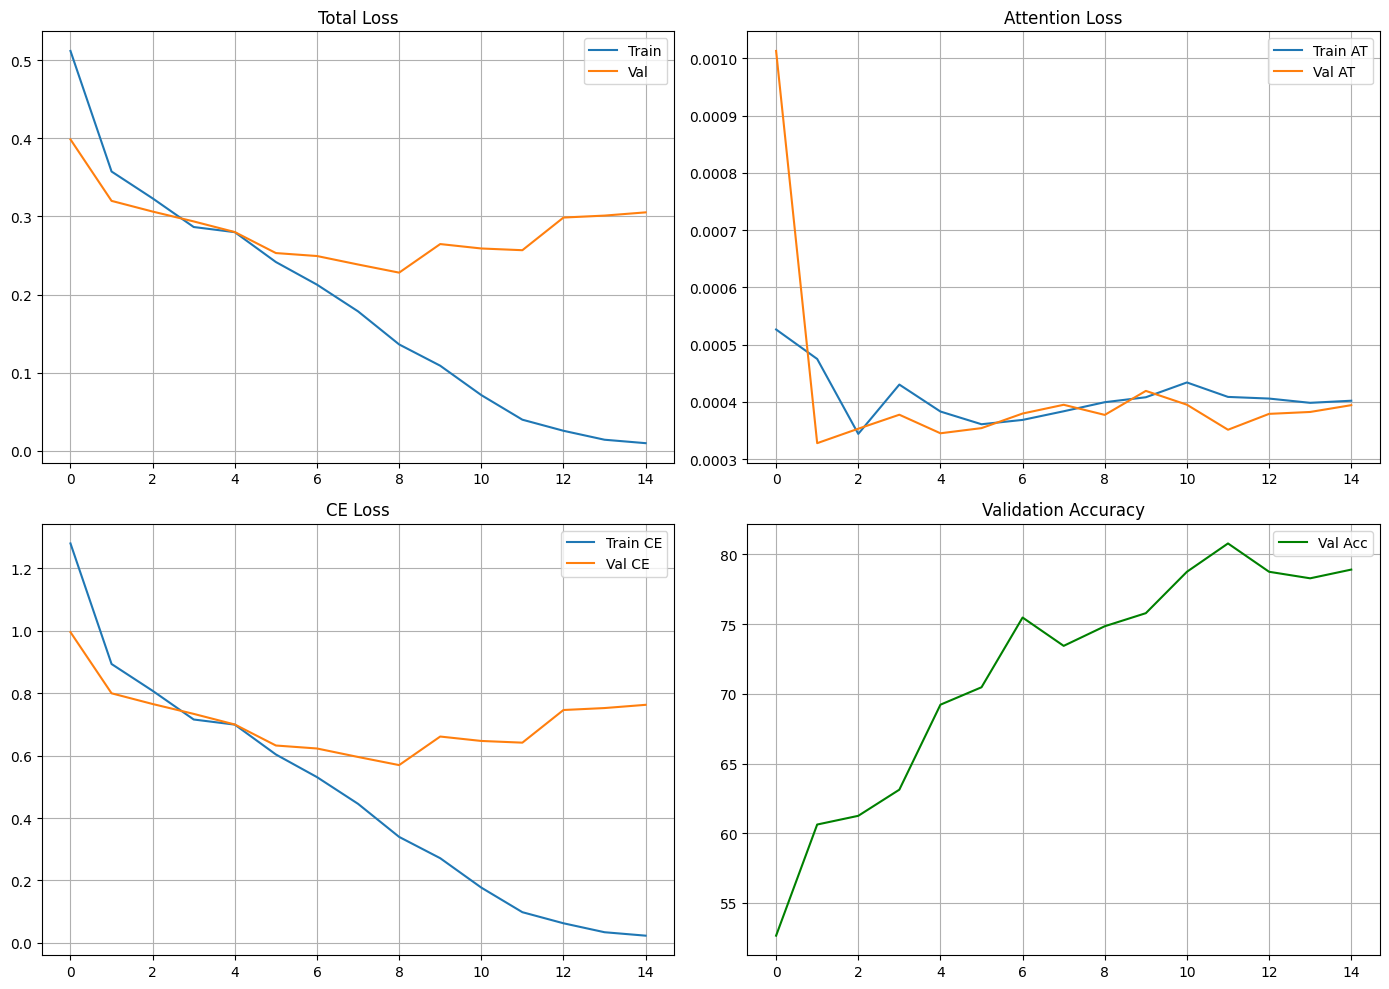

In [20]:
# ==============================
# Визуализация метрик
# ==============================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].plot(history['train_loss'], label='Train'); axes[0,0].plot(history['val_loss'], label='Val'); axes[0,0].set_title('Total Loss'); axes[0,0].legend(); axes[0,0].grid(True)
axes[0,1].plot(history['train_attn'], label='Train AT'); axes[0,1].plot(history['val_attn'], label='Val AT'); axes[0,1].set_title('Attention Loss'); axes[0,1].legend(); axes[0,1].grid(True)
axes[1,0].plot(history['train_ce'], label='Train CE'); axes[1,0].plot(history['val_ce'], label='Val CE'); axes[1,0].set_title('CE Loss'); axes[1,0].legend(); axes[1,0].grid(True)
axes[1,1].plot(history['val_acc'], label='Val Acc', color='green'); axes[1,1].set_title('Validation Accuracy'); axes[1,1].legend(); axes[1,1].grid(True)
plt.tight_layout()
plt.savefig('attention_s_training_history.png', dpi=150, bbox_inches='tight')
print('📈 История обучения сохранена: attention_s_training_history.png')
plt.show()
